# Imports

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [2]:
fs = 200
dataset = reader.load_dataset(constants.MASS_SS_NAME, params={pkeys.FS: fs})
subject_ids = dataset.all_ids
signals = dataset.get_signals(normalize_clip=False)
hypnos = dataset.get_hypnograms()
stamps_ss = dataset.get_stamps(which_expert=1, pages_subset=constants.N2_RECORD)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [ ]:
# stages ids ['1', '2', '3', '4', 'R', 'W', '?']
for i, single_subject in enumerate(subject_ids):
    print("\nSubjectd %02d" % single_subject)
    single_signal = signals[i]
    single_hypno = hypnos[i]
    n_pages = len(single_hypno)
    pages = [p for p in range(n_pages) if single_hypno[p] in ['1', '2', '3', '4']]
    nrem_signal = utils.extract_pages(single_signal, pages, dataset.page_size, border_size=0).flatten()
    all_std = single_signal.std()
    nrem_std = nrem_signal.std()
    print("Broad-band EEG  : All-std %1.2f -- NREM std %1.2f" % (all_std, nrem_std))
    # Filter
    lowcut = 4
    highcut = 20
    filtered_signal = utils.broad_filter(single_signal, fs, lowcut=lowcut, highcut=highcut)
    nrem_signal = utils.extract_pages(filtered_signal, pages, dataset.page_size, border_size=0).flatten()
    all_std = filtered_signal.std()
    nrem_std = nrem_signal.std()
    print("Filtered %d-%d Hz: All-std %1.2f -- NREM std %1.2f" % (lowcut, highcut, all_std, nrem_std))

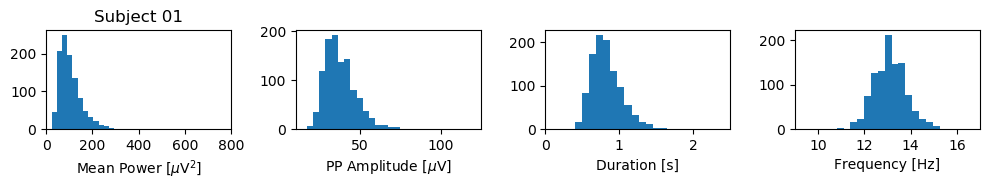

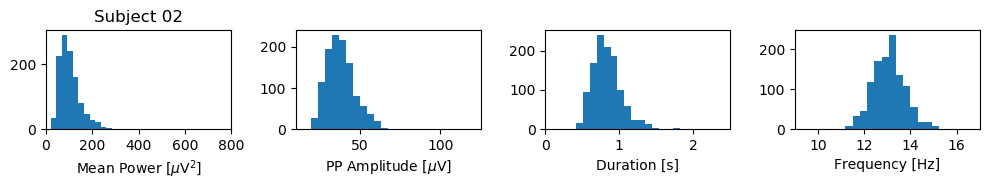

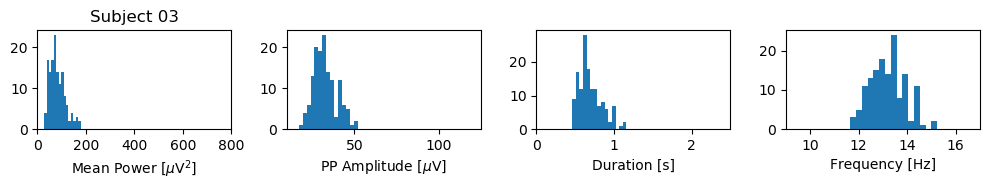

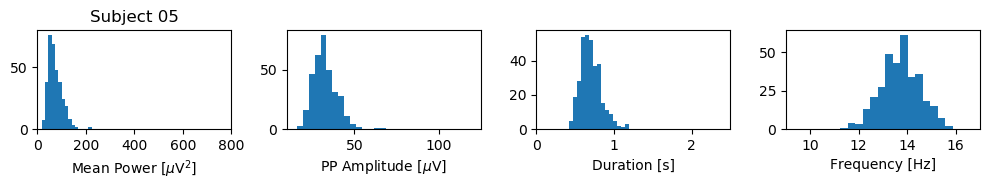

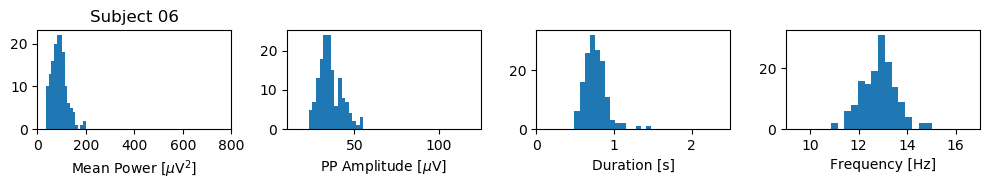

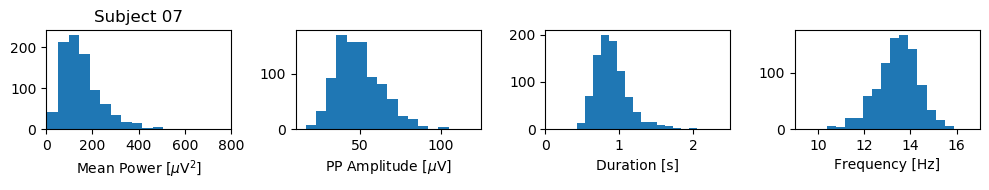

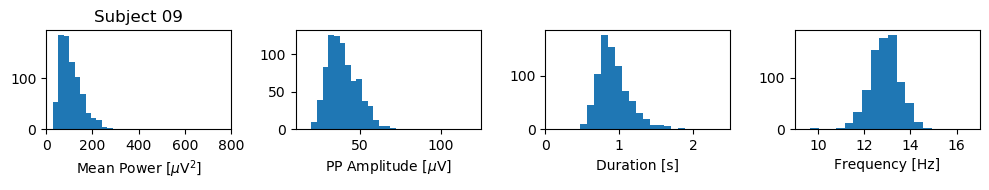

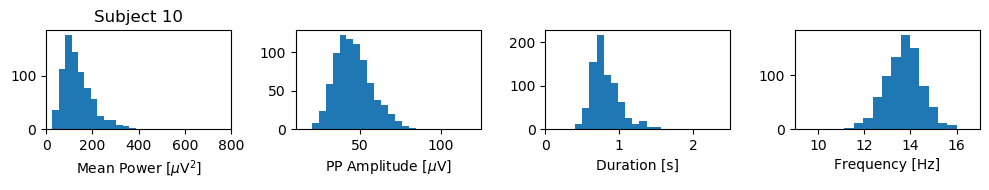

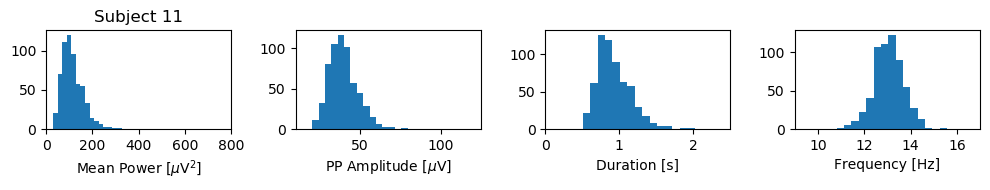

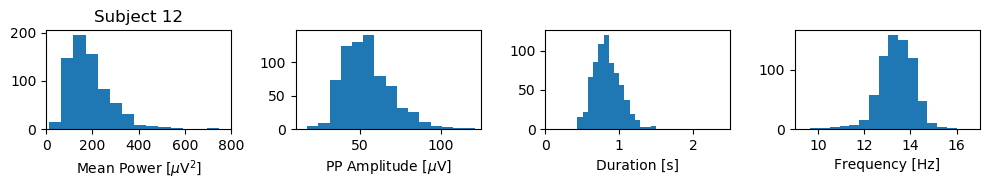

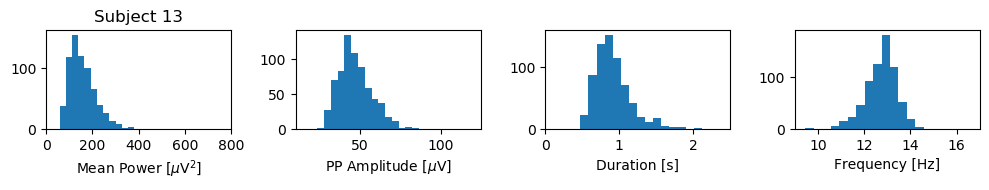

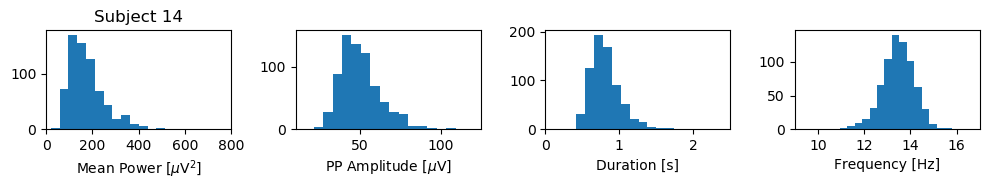

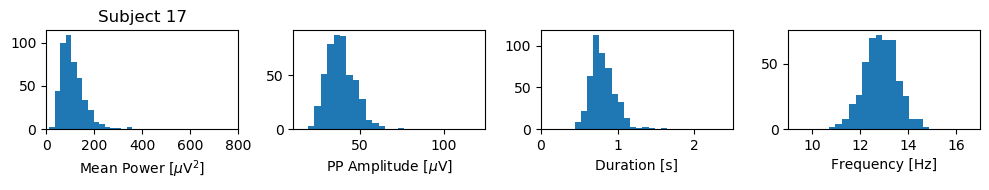

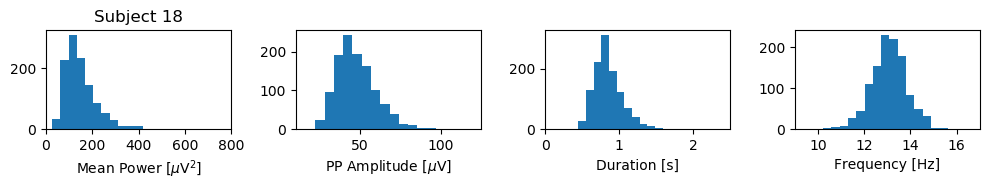

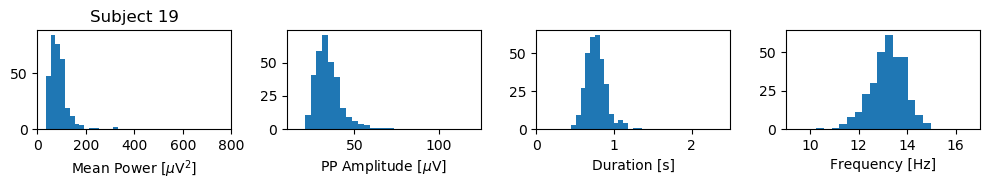

In [52]:
for subject_id in subject_ids:
    subject_loc = subject_ids.index(subject_id)
    single_signal = signals[subject_loc]
    single_hypno = hypnos[subject_loc]
    single_stamps = stamps_ss[subject_loc]
    filtered_signal = utils.broad_filter(single_signal, fs, lowcut=9, highcut=16)

    signal_in_stamps = [single_signal[start_sample:end_sample] for start_sample, end_sample in single_stamps]
    filtered_in_stamps = [filtered_signal[start_sample:end_sample] for start_sample, end_sample in single_stamps]

    # Spindle features
    power_in_stamps = np.array([np.mean(spindle ** 2) for spindle in filtered_in_stamps])
    peak2peak_in_stamps = np.array([np.max(spindle) - np.min(spindle) for spindle in filtered_in_stamps])
    duration_in_stamps = np.array([spindle.size / fs for spindle in filtered_in_stamps])
    frequency_in_stamps = np.array([find_peaks(spindle)[0].size * fs / spindle.size for spindle in filtered_in_stamps])

    fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=100)
    axes[0].set_title("Subject %02d" % subject_id)
    axes[0].hist(power_in_stamps, bins=15)
    axes[0].set_xlabel("Mean Power [$\mu$V$^2$]")
    axes[0].set_xlim([0, 800])
    axes[1].hist(peak2peak_in_stamps, bins=15)
    axes[1].set_xlabel("PP Amplitude [$\mu$V]")
    axes[1].set_xlim([10, 125])
    axes[2].hist(duration_in_stamps, bins=15)
    axes[2].set_xlabel("Duration [s]")
    axes[2].set_xlim([0, 2.5])
    axes[3].hist(frequency_in_stamps, bins=15)
    axes[3].set_xlabel("Frequency [Hz]")
    axes[3].set_xlim([9, 17])
    plt.tight_layout()
    plt.show()